In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from torch import optim
from torch.optim.adam import Adam

from torchvision.datasets import CIFAR10 # type: ignore
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda # type: ignore
from torchvision.models import vgg16_bn

import utils

import matplotlib.pyplot as plt

In [2]:
class RGB2YUV:
    @staticmethod
    def __call__(rgb: Tensor) -> Tensor:     
        m = torch.tensor([[0.29900, -0.16874,  0.50000],
                          [0.58700, -0.33126, -0.41869],
                          [0.11400,  0.50000, -0.08131]])
        
        yuv = (rgb.permute(1, 2, 0) @ m).permute(2, 0, 1)
        yuv[1:, :, :] += 0.5
        return yuv


class Normalization:
    m: Tensor
    s: Tensor

    def __init__(self, kernel_size: int = 7, sigma: float = 1.0) -> None:
        self.kernel_size = kernel_size
        self.sigma = sigma

    @property
    def gaussian_kernel(self) -> Tensor:
        x = torch.arange(self.kernel_size).float() - self.kernel_size // 2
        gaussian_1d = torch.exp(-0.5 * (x / self.sigma).pow(2))
        gaussian_2d = gaussian_1d[:, None] * gaussian_1d[None, :]
        gaussian_2d /= gaussian_2d.sum()
        return gaussian_2d.expand(1, 1, -1, -1)

    def fit(self, imgs: Tensor) -> None:
        uv_channels = imgs[:, 1:]
        self.m = uv_channels.mean((0, 2, 3), keepdims=True)
        self.s = uv_channels.std((0, 2, 3), keepdims=True)

    def transform(self, imgs: Tensor) -> Tensor:
        y_channel = imgs[:, :1]
        uv_channels = imgs[:, 1:]
        
        y_blurred = torch.nn.functional.conv2d(y_channel, self.gaussian_kernel, padding=self.kernel_size // 2)
        y_normalized = y_channel - y_blurred
        y_normalized /= y_normalized.std((2, 3), keepdims=True) + 1e-5
        
        uv_normalized = (uv_channels - self.m) / self.s

        return torch.cat([y_normalized, uv_normalized], 1)

    def fit_transform(self, imgs: Tensor) -> Tensor:
        self.fit(imgs)
        return self.transform(imgs)


class StandardScaler:
    m: Tensor
    s: Tensor

    def __init__(self, dims: int | tuple[int, ...]):
        self.dims = dims

    def fit(self, t: torch.Tensor):
        self.m = t.mean(self.dims, keepdims=True)
        self.s = t.std(self.dims, keepdims=True)

    def transform(self, t: Tensor):
        return (t - self.m) / self.s

    def fit_transform(self, t: Tensor):
        self.fit(t)
        return self.transform(t)


def get_images(dataset):
    return torch.stack([el[0] for el in dataset])


def get_targets(dataset):
    return torch.tensor([el[1] for el in dataset])


transform = Compose([
    ToTensor(),
    RGB2YUV(),
])

raw_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
raw_test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

norm = Normalization()
train_dataset = TensorDataset(norm.fit_transform(get_images(raw_train_dataset)), get_targets(raw_train_dataset))
test_dataset = TensorDataset(norm.transform(get_images(raw_test_dataset)), get_targets(raw_test_dataset))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# transform = Compose([
#     # transforms.Resize((224, 224)),
#     ToTensor(),
#     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize as required
# ])

# train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

In [4]:
train_loader: DataLoader[tuple[Tensor, Tensor]] = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader: DataLoader[tuple[Tensor, Tensor]] = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
cfgs = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [6]:
vgg = utils.VGG(cfgs['VGG16'])
# state_dict = {k: v for k, v in vgg16_bn(pretrained=True).state_dict().items() if not k.startswith('classifier')}

vgg.load_state_dict(torch.load('vgg16-89.33%.pth'))
# vgg.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
bayesian_vgg = utils.BayesianVGG(cfgs['VGG16'])
bayesian_vgg.from_vgg(vgg)

# state_dict = {k: v for k, v in vgg16_bn(pretrained=True).state_dict().items() if not k.startswith('classifier')}
# bayesian_vgg.load_state_dict(state_dict, strict=False)

# for bayesian_layer in bayesian_vgg.get_bayesian_layers():
#     bayesian_layer.weight_std.data = bayesian_layer.weight.data * 1e-4

optimizer = optim.Adam(bayesian_vgg.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.6)


def reg_coef_lambda(epoch: int) -> float:
    return min(1., 0.5 ** (8 - epoch // 50))

# optimizer = optim.Adam(bayesian_vgg.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)


# def reg_coef_lambda(epoch: int) -> float:
#     return min(1., 0.5 ** (10 - epoch // 10))

In [8]:
trainer = utils.BayesianModelTrainer(bayesian_vgg, train_loader, test_loader, optimizer, scheduler, epochs=500, reg_coef_lambda=reg_coef_lambda)
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


accuracy,▁▃▆▆▇▇███▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_loss,▁▄▆▆▇▇▆▇██▇███▇▇▆▇▆▆▇▆▅▅▆▆▆▆▆▆▆▆▇▆▇▆▆▆▇▆
loss,▄▁▁▁▂▃▁▁▁▂▂▁▂▂▁▁▁▂▂▁▅▃▄▂▄▂▂▅▅▄▅▅▅█▄▅▆▄▅▆
neuron_sparsity_0,▁▁▁▁▁▁▁▁▁▁▁▂▄▄▄▇▇▇▇▇████████████████████
neuron_sparsity_1,▅▂▂▂▁▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
neuron_sparsity_10,▁▃▆▃▅▃▄▅▆▇██████████████████████████████
neuron_sparsity_11,▁▄▇▄▇▇▇▇████████████████████████████████
neuron_sparsity_12,▁▁▂▁▃▄▄▄▄▅▅▅▆▆▇▇▇▇██████████████████████
neuron_sparsity_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
neuron_sparsity_3,▁▂▂▁▅▁▇█████████████████████████████████


In [9]:
test_metrics = trainer.test(500)
[int(n * (1 - value)) for n, (_, value) in zip(filter(lambda cfg: cfg != "M", cfgs["VGG16"]), filter(lambda kv: kv[0].startswith("neuron_sparsity"), test_metrics.items()))]

[59, 53, 127, 117, 242, 237, 215, 378, 139, 76, 16, 15, 110]

In [10]:
threshold = 1 - 1e-10

for layer in bayesian_vgg.get_bayesian_layers():
    layer.threshold = threshold
trainer.threshold = threshold

test_metrics = trainer.test(500)

for layer in bayesian_vgg.get_bayesian_layers():
    layer.threshold = 0.99
trainer.threshold = 0.99

test_metrics

{'eval_loss': 0.6583730220794678,
 'accuracy': 88.58,
 'epoch': 500,
 'sparsity_0': 0.078125,
 'neuron_sparsity_0': 0.078125,
 'sparsity_1': 0.2124565839767456,
 'neuron_sparsity_1': 0.15625,
 'sparsity_2': 0.1636013388633728,
 'neuron_sparsity_2': 0.0078125,
 'sparsity_3': 0.0872463583946228,
 'neuron_sparsity_3': 0.0859375,
 'sparsity_4': 0.1394992470741272,
 'neuron_sparsity_4': 0.046875,
 'sparsity_5': 0.1234588623046875,
 'neuron_sparsity_5': 0.0703125,
 'sparsity_6': 0.2025333046913147,
 'neuron_sparsity_6': 0.15625,
 'sparsity_7': 0.3745591640472412,
 'neuron_sparsity_7': 0.25390625,
 'sparsity_8': 0.7984521389007568,
 'neuron_sparsity_8': 0.728515625,
 'sparsity_9': 0.9594849348068237,
 'neuron_sparsity_9': 0.849609375,
 'sparsity_10': 0.9769736528396606,
 'neuron_sparsity_10': 0.96875,
 'sparsity_11': 0.9990365505218506,
 'neuron_sparsity_11': 0.970703125,
 'sparsity_12': 0.9870779514312744,
 'neuron_sparsity_12': 0.240234375,
 'total_neuron_sparsity': 50.92329545454545}

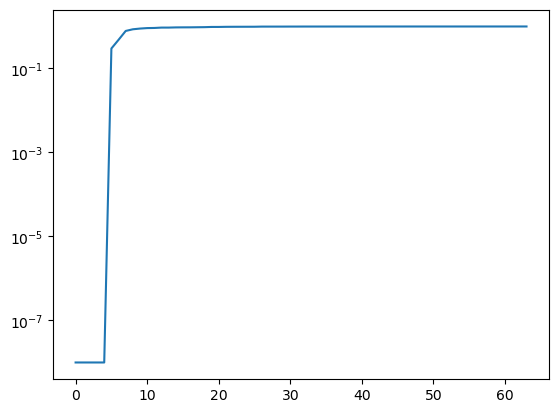

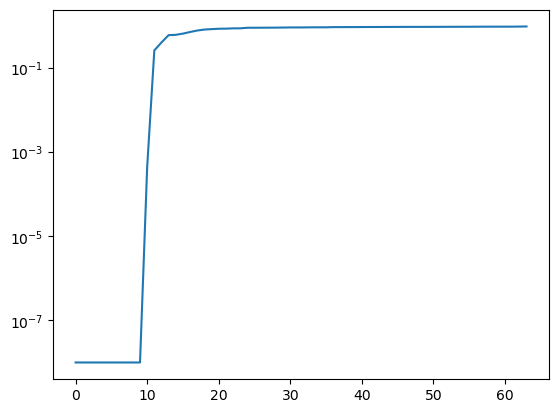

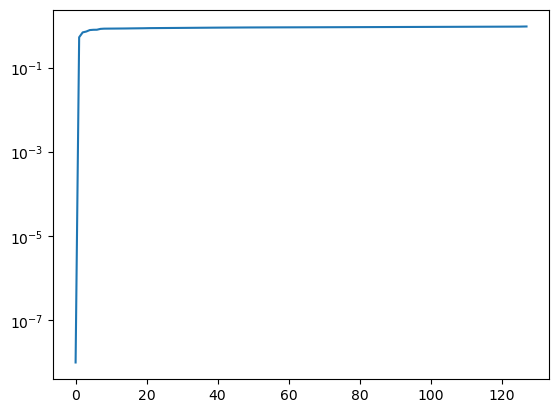

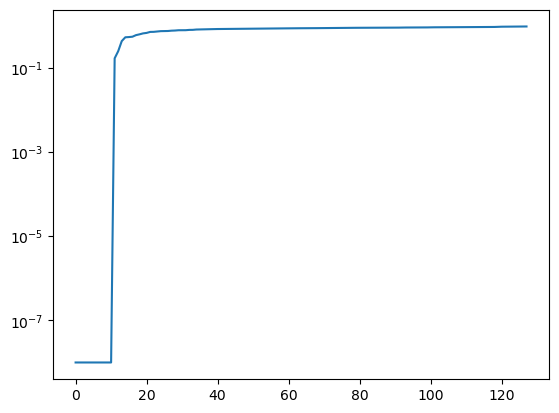

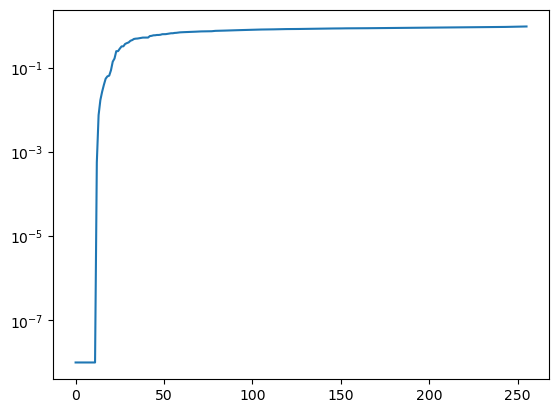

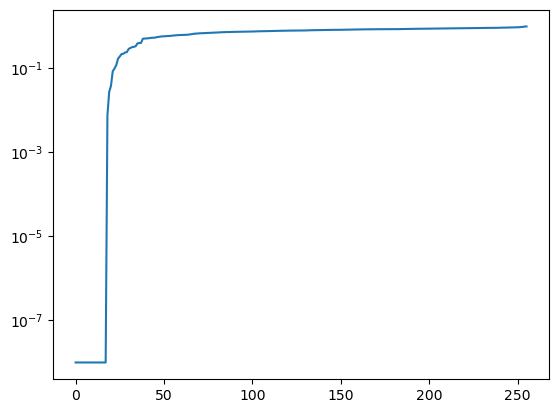

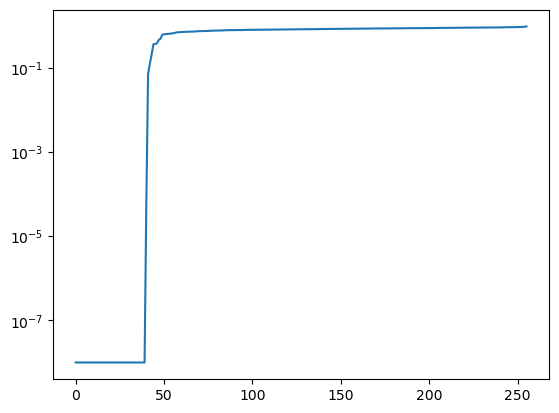

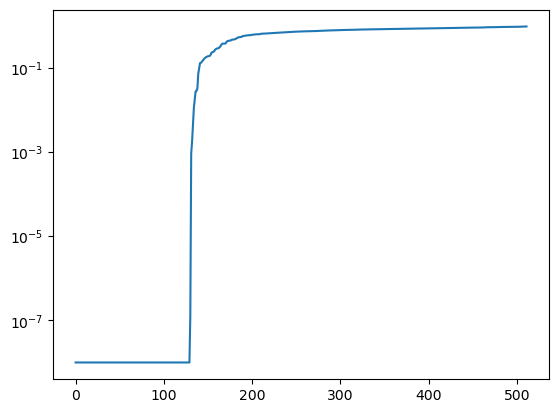

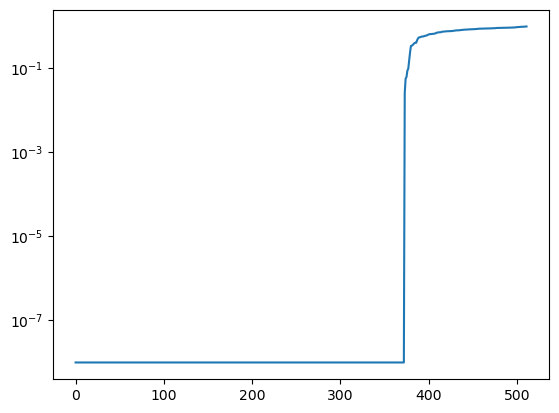

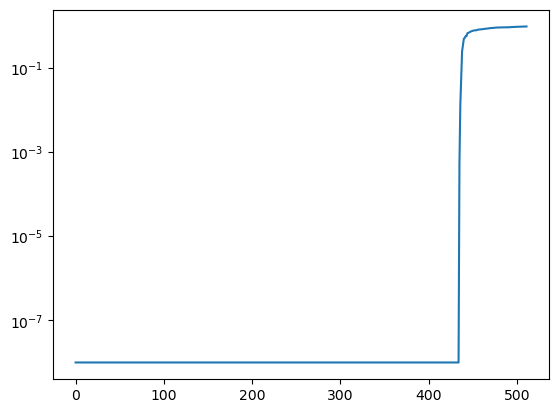

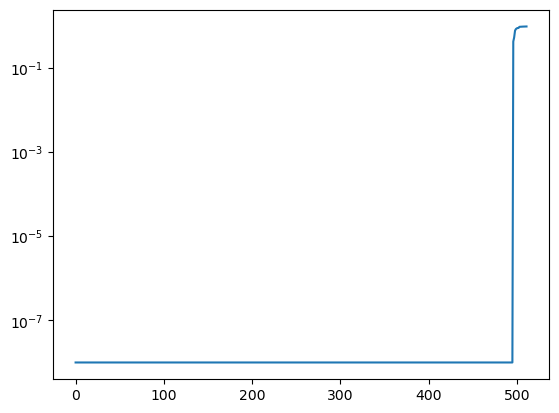

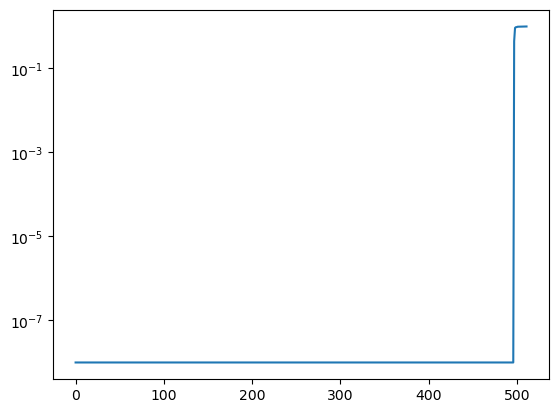

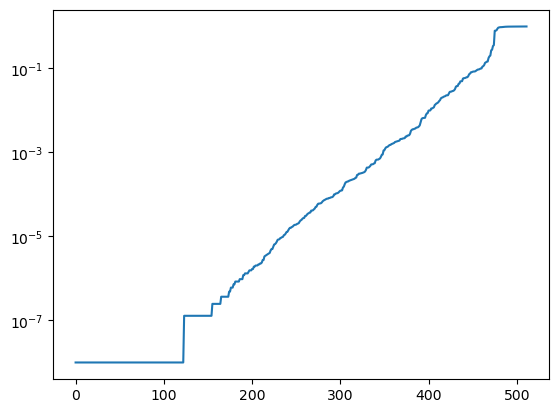

In [11]:
for layer in bayesian_vgg.get_bayesian_layers():
    plt.figure()
    plt.plot(range(layer.weight.shape[0]), sorted(1 - layer.equivalent_dropout_rate.amin((1, 2, 3)).detach().cpu() + 1e-8))
    plt.yscale('log')

In [13]:
torch.save(bayesian_vgg.state_dict(), 'bayesian-vgg16.pth')

In [12]:
(1 - 1 / (100 * 64)) ** 64

0.9900490601924598